In [2]:
import torch
import  torch.nn.functional as F
import matplotlib.pyplot as plt

In [3]:
words = open('datasets/names.txt').read().splitlines()
print(words[:10])  # Print the first 10 words to verify
print(f"Total words loaded: {len(words)}")

chars = sorted(list(set(''.join(words))))

# string to index mapping 
stoi = { ch:i+1 for i,ch in enumerate(chars)}
stoi['.'] = 0
print(f"String to index mapping: {stoi}")

itos = {i:s for s,i in stoi.items()}
print(itos)

vocab_size = len(itos)

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']
Total words loaded: 32033
String to index mapping: {'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [ ]:
# Build the dataset
import random
from typing import List

block_size = 3

def build_dataset(words: List[str], context_len: int=3):
    block_size = context_len 
    
    X,Y = [],[]

    for w in words:
        context = [0] * block_size

        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)

            # print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix]

    # print(X)
    X = torch.tensor(X)
    Y = torch.tensor(Y)

    return X,Y
    # X.shape, X.dtype, Y.shape, Y.dtype


random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

X_train,Y_train = build_dataset(words[:n1],block_size)
X_dev,Y_dev = build_dataset(words[n1:n2],block_size)
X_test,Y_test = build_dataset(words[n2:],block_size)

X_train.shape, X_dev.shape, X_test.shape

(torch.Size([182580, 8]), torch.Size([22767, 8]), torch.Size([22799, 8]))

In [4]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / (fan_in**0.5)
        self.bias = torch.zeros(fan_out) if bias else None 
    
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum 
        self.Training = True

        # parameters to learn
        self.gamma = torch.ones(dim) # gain/scale
        self.beta = torch.zeros(dim) # bias/shift

        # running stats used for inference time
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.Training:
            batch_mean = x.mean(0,keepdim=True)
            batch_var = x.var(0,keepdim=True) 

            xhat = (x - batch_mean)/(torch.sqrt(batch_var + self.eps))
            self.out = self.gamma * xhat + self.beta

            # update running stats to be used at inference time
            # this enables us to even input a single sample at the inference time which then
            # helps to normalize the input sample before preactivation
            with torch.no_grad(): # context manager to prevent gradient tracking, as pytorch builds a computation graph by default.
                self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * batch_mean
                self.running_var = (1-self.momentum) * self.running_var + self.momentum * batch_var
        else:
            xhat = (x - self.running_mean)/(torch.sqrt(self.running_var + self.eps))
            self.out = self.gamma * xhat + self.beta
        
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:

    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

class Embedding:

    # num_embeddings: size of the vocabulary
    # embedding_dim: size of each embedding vector
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim)) 
    
    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out
    
    def parameters(self):
        return [self.weight]
    
class Flatten:

    def __call__(self, x):
        self.out = x.view(x.shape[0], -1)
        return self.out
    
    def parameters(self):
        return []

class Sequential:

    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


In [5]:
torch.manual_seed(42)

In [6]:
n_embed = 10
n_hidden = 100

model = Sequential([
    Embedding(vocab_size, n_embed),
    Flatten(),
    Linear(n_embed*block_size, n_hidden,bias=True),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden, bias=True),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, vocab_size),
])

with torch.no_grad():
    # making the output softmax less confident [correct loss initialization]
    # this prevents the hockey stick loss curve at the beginning of training
    model.layers[-1].weight *= 0.01
    # layers[-1].weight *= 0.01

    # for layer in layers[:-1]:
    #     if isinstance(layer, Linear):
    #         layer.weight *= 5/3 # 1 #5/3 # scale/gain

parameters = model.parameters() 

print(sum(p.nelement() for p in parameters)) # p is the matrix/weight/bias/tensor

for p in parameters:
    p.requires_grad = True



16597


In [7]:
max_steps = 200000
batch_size = 32
loss_i = []

for epochs in range(max_steps):

    ix = torch.randint(0, X_train.shape[0], (batch_size,))
    Xb, Yb = X_train[ix], Y_train[ix] # batch X and Y

    # forward pass
    logits = model(Xb)
    
    loss = F.cross_entropy(logits, Yb)

    for p in parameters:
        p.grad = None
    
    loss.backward()

    lr = 0.01 if epochs < max_steps/2 else 0.001 

    for p in parameters:
        p.data += -lr * p.grad

    # tracking stats
    if epochs % 10000 == 0:
        print(f"Step {epochs}/{max_steps:7d}, Loss: {loss.item():.4f}, Learning Rate: {lr:.4f}")
    loss_i.append(loss.log10().item())


Step 0/ 200000, Loss: 3.2961, Learning Rate: 0.0100
Step 10000/ 200000, Loss: 2.5985, Learning Rate: 0.0100
Step 20000/ 200000, Loss: 2.2241, Learning Rate: 0.0100
Step 30000/ 200000, Loss: 2.3096, Learning Rate: 0.0100
Step 40000/ 200000, Loss: 2.2026, Learning Rate: 0.0100
Step 50000/ 200000, Loss: 1.7810, Learning Rate: 0.0100
Step 60000/ 200000, Loss: 2.1633, Learning Rate: 0.0100
Step 70000/ 200000, Loss: 2.3472, Learning Rate: 0.0100
Step 80000/ 200000, Loss: 2.2590, Learning Rate: 0.0100
Step 90000/ 200000, Loss: 1.8782, Learning Rate: 0.0100
Step 100000/ 200000, Loss: 2.0635, Learning Rate: 0.0010
Step 110000/ 200000, Loss: 2.2753, Learning Rate: 0.0010
Step 120000/ 200000, Loss: 2.2778, Learning Rate: 0.0010
Step 130000/ 200000, Loss: 2.1153, Learning Rate: 0.0010
Step 140000/ 200000, Loss: 2.8466, Learning Rate: 0.0010
Step 150000/ 200000, Loss: 2.0275, Learning Rate: 0.0010
Step 160000/ 200000, Loss: 2.1518, Learning Rate: 0.0010
Step 170000/ 200000, Loss: 2.4276, Learning R

This is having a zig-zag shape because the batch_size taken by us is very small.

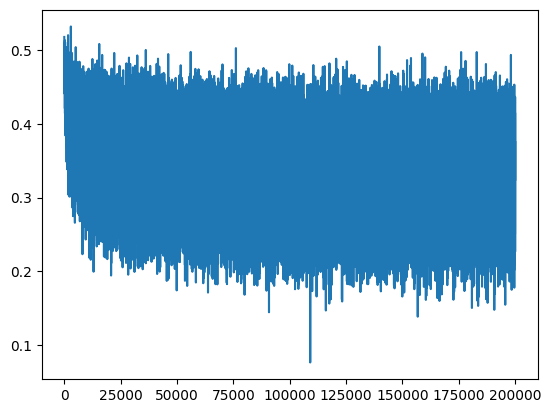

In [8]:
plt.plot(loss_i)

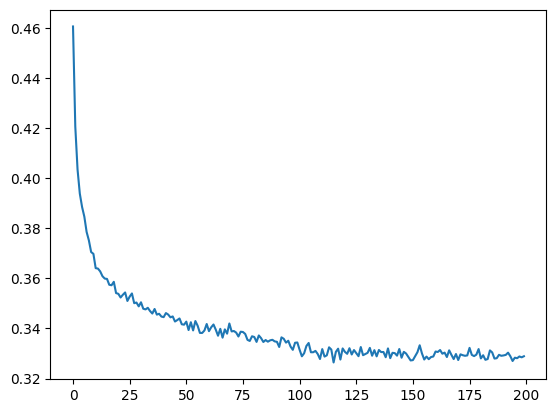

In [9]:
plt.plot(torch.tensor(loss_i).view(-1,1000).mean(1))

In [10]:
# putting the layers to eval mode (must for batch_norm)

for layer in model.layers:
    if isinstance(layer, BatchNorm1d):
        layer.Training = False


In [11]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': {X_train,Y_train},
        'dev': {X_dev,Y_dev},
        'test': {X_test,Y_test}
    }[split]

    logits = model(x)
    loss = F.cross_entropy(logits,y)

    print(split,loss.item())

split_loss('train')
split_loss('dev')


train 2.1149344444274902
dev 2.139407157897949


As the train and dev loss are similar to each other, we are not overfitting. Hence we can make additional progress in this by scaling up our neural network. 

In [12]:
# sample from the model

for i in range(20):
    out = []
    context = [0] * block_size

    while True:
        
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits,dim=1) # (1,vocab_size)
        ix = torch.multinomial(probs, num_samples=1).item()

        context = context[1:] + [ix]

        if ix == 0:
            break 
        
        out.append(itos[ix])
    
    print(''.join(ele for ele in out))
    # print(out)



chylin
jola
barum
kayceson
reel
kaely
jasar
hanna
mah
beah
acriyona
darabelle
rida
shakomariqunidy
dethirik
dely
elynn
zaylei
koelliannasti
kard


In [2]:
import torch
import  torch.nn.functional as F
import matplotlib.pyplot as plt

words = open('datasets/names.txt').read().splitlines()
print(words[:10])  # Print the first 10 words to verify
print(f"Total words loaded: {len(words)}")

chars = sorted(list(set(''.join(words))))

# string to index mapping 
stoi = { ch:i+1 for i,ch in enumerate(chars)}
stoi['.'] = 0
print(f"String to index mapping: {stoi}")

itos = {i:s for s,i in stoi.items()}
print(itos)

vocab_size = len(itos)

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']
Total words loaded: 32033
String to index mapping: {'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [3]:
# Build the dataset
import random
from typing import List

block_size = 8

def build_dataset(words: List[str], context_len: int=3):
    block_size = context_len 
    
    X,Y = [],[]

    for w in words:
        context = [0] * block_size

        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)

            # print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix]

    # print(X)
    X = torch.tensor(X)
    Y = torch.tensor(Y)

    return X,Y
    # X.shape, X.dtype, Y.shape, Y.dtype


random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

X_train,Y_train = build_dataset(words[:n1],block_size)
X_dev,Y_dev = build_dataset(words[n1:n2],block_size)
X_test,Y_test = build_dataset(words[n2:],block_size)

print(X_train.shape, X_dev.shape, X_test.shape)
print(X_test[0:5])

torch.Size([182625, 8]) torch.Size([22655, 8]) torch.Size([22866, 8])
tensor([[ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0, 13],
        [ 0,  0,  0,  0,  0,  0, 13, 21],
        [ 0,  0,  0,  0,  0, 13, 21, 19],
        [ 0,  0,  0,  0, 13, 21, 19, 20]])


In [5]:
n_embed = 10
n_hidden = 100

model = Sequential([
    Embedding(vocab_size, n_embed),
    Flatten(),
    Linear(n_embed*block_size, n_hidden,bias=True),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden, bias=True),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, vocab_size),
])

with torch.no_grad():
    # making the output softmax less confident [correct loss initialization]
    # this prevents the hockey stick loss curve at the beginning of training
    model.layers[-1].weight *= 0.01
    # layers[-1].weight *= 0.01

    # for layer in layers[:-1]:
    #     if isinstance(layer, Linear):
    #         layer.weight *= 5/3 # 1 #5/3 # scale/gain

parameters = model.parameters() 

print(sum(p.nelement() for p in parameters)) # p is the matrix/weight/bias/tensor

for p in parameters:
    p.requires_grad = True



21597


In [6]:
max_steps = 200000
batch_size = 32
loss_i = []

for epochs in range(max_steps):

    ix = torch.randint(0, X_train.shape[0], (batch_size,))
    Xb, Yb = X_train[ix], Y_train[ix] # batch X and Y

    # forward pass
    logits = model(Xb)
    
    loss = F.cross_entropy(logits, Yb)

    for p in parameters:
        p.grad = None
    
    loss.backward()

    lr = 0.01 if epochs < max_steps/2 else 0.001 

    for p in parameters:
        p.data += -lr * p.grad

    # tracking stats
    if epochs % 10000 == 0:
        print(f"Step {epochs}/{max_steps:7d}, Loss: {loss.item():.4f}, Learning Rate: {lr:.4f}")
    loss_i.append(loss.log10().item())


Step 0/ 200000, Loss: 3.2957, Learning Rate: 0.0100
Step 10000/ 200000, Loss: 2.0392, Learning Rate: 0.0100
Step 20000/ 200000, Loss: 1.9929, Learning Rate: 0.0100
Step 30000/ 200000, Loss: 2.4502, Learning Rate: 0.0100
Step 40000/ 200000, Loss: 2.0272, Learning Rate: 0.0100
Step 50000/ 200000, Loss: 2.1802, Learning Rate: 0.0100
Step 60000/ 200000, Loss: 2.2102, Learning Rate: 0.0100
Step 70000/ 200000, Loss: 2.3747, Learning Rate: 0.0100
Step 80000/ 200000, Loss: 1.8728, Learning Rate: 0.0100
Step 90000/ 200000, Loss: 1.8191, Learning Rate: 0.0100
Step 100000/ 200000, Loss: 2.1334, Learning Rate: 0.0010
Step 110000/ 200000, Loss: 2.0533, Learning Rate: 0.0010
Step 120000/ 200000, Loss: 2.2170, Learning Rate: 0.0010
Step 130000/ 200000, Loss: 1.8550, Learning Rate: 0.0010
Step 140000/ 200000, Loss: 2.1682, Learning Rate: 0.0010
Step 150000/ 200000, Loss: 1.9773, Learning Rate: 0.0010
Step 160000/ 200000, Loss: 2.1511, Learning Rate: 0.0010
Step 170000/ 200000, Loss: 1.7804, Learning R

In [7]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': {X_train,Y_train},
        'dev': {X_dev,Y_dev},
        'test': {X_test,Y_test}
    }[split]

    logits = model(x)
    loss = F.cross_entropy(logits,y)

    print(split,loss.item())

split_loss('train')
split_loss('dev')


train 2.0303843021392822
dev 2.0781359672546387


### Performance Log:

* Original (3 character context + 100 hidden neurons) ->  train 2.1149, dev 2.1394
* Increasing the context: (8 character context + 100 hidden neurons) -> train 2.0219, dev 2.0794

In [18]:
print(block_size)

8


In [8]:
# putting the layers to eval mode (must for batch_norm)

for layer in model.layers:
    if isinstance(layer, BatchNorm1d):
        layer.Training = False

In [9]:
# sample from the model

for i in range(20):
    out = []
    context = [0] * block_size

    while True:
        
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits,dim=1) # (1,vocab_size)
        ix = torch.multinomial(probs, num_samples=1).item()

        context = context[1:] + [ix]

        if ix == 0:
            break 
        
        out.append(itos[ix])
    
    print(''.join(ele for ele in out))
    # print(out)



mekenije
muskota
lahainia
samayah
bliiah
marita
bylin
kli
mityn
matiya
abi
linshem
jayden
miteli
lalaaniheh
fameer
meemi
leisa
jarlee
dakkysa


In [13]:
ix = torch.randint(0, X_train.shape[0], (4,))
Xb, Yb = X_train[ix], Y_train[ix] 
logits = model(Xb)
Xb.shape

torch.Size([4, 8])

Flattening Logic

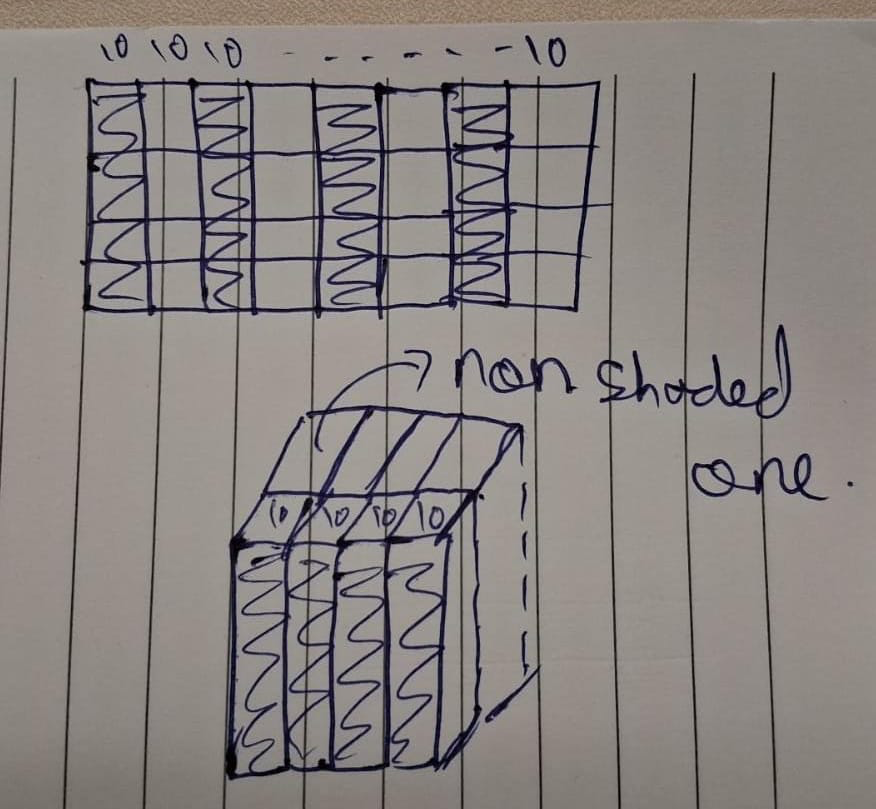

In [17]:
e = torch.randn(4,8,10) # -> torch.randn(4, 4, 20)

e = torch.concat([e[:,::2,:],e[:,1::2,:]],dim=2)
e.shape

torch.Size([4, 4, 20])

In [69]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / (fan_in**0.5)
        self.bias = torch.zeros(fan_out) if bias else None 
    
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum 
        self.Training = True

        # parameters to learn
        self.gamma = torch.ones(dim) # gain/scale
        self.beta = torch.zeros(dim) # bias/shift

        # running stats used for inference time
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x): 

        if self.Training:

            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0,1)
                
            batch_mean = x.mean(dim,keepdim=True)
            batch_var = x.var(dim,keepdim=True) 

            xhat = (x - batch_mean)/(torch.sqrt(batch_var + self.eps))
            self.out = self.gamma * xhat + self.beta

            # update running stats to be used at inference time
            # this enables us to even input a single sample at the inference time which then
            # helps to normalize the input sample before preactivation
            with torch.no_grad(): # context manager to prevent gradient tracking, as pytorch builds a computation graph by default.
                self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * batch_mean
                self.running_var = (1-self.momentum) * self.running_var + self.momentum * batch_var
        else:
            xhat = (x - self.running_mean)/(torch.sqrt(self.running_var + self.eps))
            self.out = self.gamma * xhat + self.beta
        
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:

    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

class Embedding:

    # num_embeddings: size of the vocabulary
    # embedding_dim: size of each embedding vector
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim)) 
    
    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out
    
    def parameters(self):
        return [self.weight]
    
class FlattenConsecutive:
    # the num of elements that are consecutive that we would like to concatenate
    # now in the last dimension of the output
    # it will take only n consecutive elements and concatenate them in the last dimension
    def __init__(self, n):
        self.n = n


    def __call__(self, x):
        B,T,C = x.shape # batch, time, channels
        x = x.view(B, T//self.n, C*self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        # self.out = x.view(x.shape[0], -1)
        return self.out
    
    def parameters(self):
        return []

class Sequential:

    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


torch.randint() expects integer so for dividing use //

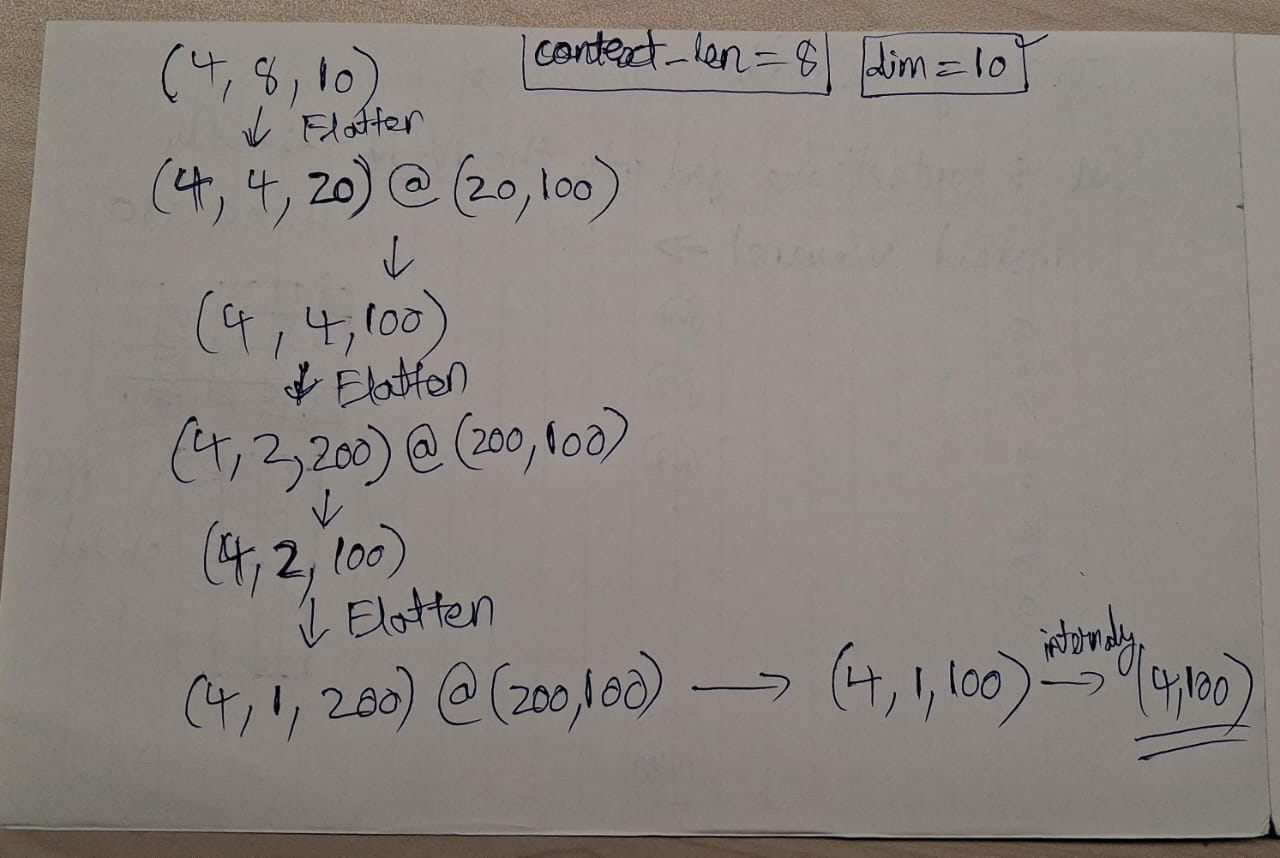

In [61]:
n_embed = 10
n_hidden = 66 # 68 as in the prev model the total parameters where around 23k

model = Sequential([
    Embedding(vocab_size, n_embed),
    FlattenConsecutive(block_size//4),
    Linear(n_embed*(block_size//4), n_hidden,bias=True),
    BatchNorm1d(n_hidden),
    Tanh(),
    FlattenConsecutive(block_size//4),
    Linear(n_hidden*(block_size//4), n_hidden,bias=True),
    BatchNorm1d(n_hidden),
    Tanh(),
    FlattenConsecutive(block_size//4),
    Linear(n_hidden*(block_size//4), n_hidden,bias=True),
    BatchNorm1d(n_hidden),
    Tanh(),
    # Linear(n_hidden, n_hidden, bias=True),
    # BatchNorm1d(n_hidden),
    # Tanh(),
    Linear(n_hidden, vocab_size),
])

with torch.no_grad():
    # making the output softmax less confident [correct loss initialization]
    # this prevents the hockey stick loss curve at the beginning of training
    model.layers[-1].weight *= 0.01
    # layers[-1].weight *= 0.01

    # for layer in layers[:-1]:
    #     if isinstance(layer, Linear):
    #         layer.weight *= 5/3 # 1 #5/3 # scale/gain

parameters = model.parameters() 

print(sum(p.nelement() for p in parameters)) # p is the matrix/weight/bias/tensor

for p in parameters:
    p.requires_grad = True



21417


In [62]:
ix = torch.randint(0, X_train.shape[0], (4,))
Xb, Yb = X_train[ix], Y_train[ix] 
logits = model(Xb)
Xb.shape

torch.Size([4, 8])

In [63]:
for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (4, 8, 10)
FlattenConsecutive : (4, 4, 20)
Linear : (4, 4, 66)
BatchNorm1d : (4, 4, 66)
Tanh : (4, 4, 66)
FlattenConsecutive : (4, 2, 132)
Linear : (4, 2, 66)
BatchNorm1d : (4, 2, 66)
Tanh : (4, 2, 66)
FlattenConsecutive : (4, 132)
Linear : (4, 66)
BatchNorm1d : (4, 66)
Tanh : (4, 66)
Linear : (4, 27)


In [64]:
max_steps = 200000
batch_size = 32
loss_i = []

for epochs in range(max_steps):

    ix = torch.randint(0, X_train.shape[0], (batch_size,))
    Xb, Yb = X_train[ix], Y_train[ix] # batch X and Y

    # forward pass
    logits = model(Xb)
    
    loss = F.cross_entropy(logits, Yb)

    for p in parameters:
        p.grad = None
    
    loss.backward()

    lr = 0.01 if epochs < max_steps/2 else 0.001 

    for p in parameters:
        p.data += -lr * p.grad

    # tracking stats
    if epochs % 10000 == 0:
        print(f"Step {epochs}/{max_steps:7d}, Loss: {loss.item():.4f}, Learning Rate: {lr:.4f}")
    loss_i.append(loss.log10().item())


Step 0/ 200000, Loss: 3.2961, Learning Rate: 0.0100
Step 10000/ 200000, Loss: 2.4543, Learning Rate: 0.0100
Step 20000/ 200000, Loss: 2.3871, Learning Rate: 0.0100
Step 30000/ 200000, Loss: 2.1626, Learning Rate: 0.0100
Step 40000/ 200000, Loss: 2.0765, Learning Rate: 0.0100
Step 50000/ 200000, Loss: 1.6227, Learning Rate: 0.0100
Step 60000/ 200000, Loss: 2.0163, Learning Rate: 0.0100
Step 70000/ 200000, Loss: 2.4028, Learning Rate: 0.0100
Step 80000/ 200000, Loss: 2.4745, Learning Rate: 0.0100
Step 90000/ 200000, Loss: 1.8604, Learning Rate: 0.0100
Step 100000/ 200000, Loss: 2.1759, Learning Rate: 0.0010
Step 110000/ 200000, Loss: 1.9688, Learning Rate: 0.0010
Step 120000/ 200000, Loss: 1.8793, Learning Rate: 0.0010
Step 130000/ 200000, Loss: 1.9991, Learning Rate: 0.0010
Step 140000/ 200000, Loss: 2.1037, Learning Rate: 0.0010
Step 150000/ 200000, Loss: 2.0483, Learning Rate: 0.0010
Step 160000/ 200000, Loss: 2.0107, Learning Rate: 0.0010
Step 170000/ 200000, Loss: 2.4122, Learning R

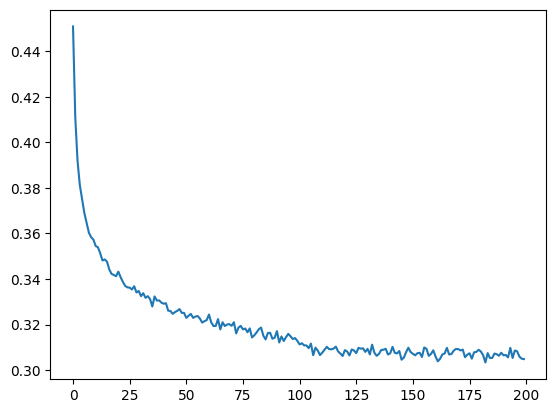

In [56]:
plt.plot(torch.tensor(loss_i).view(-1,1000).mean(1))

In [39]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': {X_train,Y_train},
        'dev': {X_dev,Y_dev},
        'test': {X_test,Y_test}
    }[split]

    logits = model(x)
    loss = F.cross_entropy(logits,y)

    print(split,loss.item())

split_loss('train')
split_loss('dev')


train 2.054682970046997
dev 2.0895886421203613


train 2.0303843021392822
dev 2.0781359672546387

to 

train 2.054682970046997
dev 2.0895886421203613



Not much of a change, What is the issue here ?

* Bug inside the batchnorm1d layer.
* And alloting parameters to different layers to be done.

The batchnorm function written by us, was for 2 dimension hence the mean calculated was for that dimension.

In [40]:
e = torch.randn(32,4,56)
emean = e.mean(0,keepdim=True)
evar = e.var(0,keepdim=True)
xhat = (e - emean)/(torch.sqrt(evar + 1e-5))
xhat.shape

torch.Size([32, 4, 56])

Lets now look at the running mean.

In [43]:
model.layers[3].running_mean.shape

torch.Size([1, 4, 56])

What is happening to the running mean and var ?

We were expecting running mean and var to be of shape (n_hidden,) i.e (56,)

which is uss particular neuron ke liye among 56 what was the approx mean that was outputed by that neuron.

In the case of 32 x 4 x 56, we are maintaining statistics for 4 positions differently. What we want is average over 32 x 4 times the output.

In [44]:
e = torch.randn(32,4,56)
emean = e.mean((0,1),keepdim=True)
evar = e.var((0,1),keepdim=True)
xhat = (e - emean)/(torch.sqrt(evar + 1e-5))
xhat.shape

torch.Size([32, 4, 56])

In [ ]:
emean.shape # and then squeeze it

torch.Size([1, 1, 56])

In [67]:
# putting the layers to eval mode (must for batch_norm)

for layer in model.layers:
    if isinstance(layer, BatchNorm1d):
        layer.Training = False

After updating the to calculate the correct running_mean and running_var.

In [68]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': {X_train,Y_train},
        'dev': {X_dev,Y_dev},
        'test': {X_test,Y_test}
    }[split]

    logits = model(x)
    loss = F.cross_entropy(logits,y)

    print(split,loss.item())

split_loss('train')
split_loss('dev')


train 2.005789279937744
dev 2.0593481063842773


train 2.0303843021392822  
dev 2.0781359672546387 

to 

train 2.005789279937744   
dev 2.0593481063842773


### Lets Scale up our Neural Network

In [70]:
n_embed = 24
n_hidden = 128 # 68 as in the prev model the total parameters where around 23k

model = Sequential([
    Embedding(vocab_size, n_embed),
    FlattenConsecutive(block_size//4),
    Linear(n_embed*(block_size//4), n_hidden,bias=True),
    BatchNorm1d(n_hidden),
    Tanh(),
    FlattenConsecutive(block_size//4),
    Linear(n_hidden*(block_size//4), n_hidden,bias=True),
    BatchNorm1d(n_hidden),
    Tanh(),
    FlattenConsecutive(block_size//4),
    Linear(n_hidden*(block_size//4), n_hidden,bias=True),
    BatchNorm1d(n_hidden),
    Tanh(),
    # Linear(n_hidden, n_hidden, bias=True),
    # BatchNorm1d(n_hidden),
    # Tanh(),
    Linear(n_hidden, vocab_size),
])

with torch.no_grad():
    # making the output softmax less confident [correct loss initialization]
    # this prevents the hockey stick loss curve at the beginning of training
    model.layers[-1].weight *= 0.01
    # layers[-1].weight *= 0.01

    # for layer in layers[:-1]:
    #     if isinstance(layer, Linear):
    #         layer.weight *= 5/3 # 1 #5/3 # scale/gain

parameters = model.parameters() 

print(sum(p.nelement() for p in parameters)) # p is the matrix/weight/bias/tensor

for p in parameters:
    p.requires_grad = True



76963


In [71]:
max_steps = 200000
batch_size = 32
loss_i = []

for epochs in range(max_steps):

    ix = torch.randint(0, X_train.shape[0], (batch_size,))
    Xb, Yb = X_train[ix], Y_train[ix] # batch X and Y

    # forward pass
    logits = model(Xb)
    
    loss = F.cross_entropy(logits, Yb)

    for p in parameters:
        p.grad = None
    
    loss.backward()

    lr = 0.01 if epochs < max_steps/2 else 0.001 

    for p in parameters:
        p.data += -lr * p.grad

    # tracking stats
    if epochs % 10000 == 0:
        print(f"Step {epochs}/{max_steps:7d}, Loss: {loss.item():.4f}, Learning Rate: {lr:.4f}")
    loss_i.append(loss.log10().item())


Step 0/ 200000, Loss: 3.2955, Learning Rate: 0.0100
Step 10000/ 200000, Loss: 2.0768, Learning Rate: 0.0100
Step 20000/ 200000, Loss: 1.8677, Learning Rate: 0.0100
Step 30000/ 200000, Loss: 2.2321, Learning Rate: 0.0100
Step 40000/ 200000, Loss: 2.3454, Learning Rate: 0.0100
Step 50000/ 200000, Loss: 2.0780, Learning Rate: 0.0100
Step 60000/ 200000, Loss: 1.8152, Learning Rate: 0.0100
Step 70000/ 200000, Loss: 2.4257, Learning Rate: 0.0100
Step 80000/ 200000, Loss: 1.8389, Learning Rate: 0.0100
Step 90000/ 200000, Loss: 1.7127, Learning Rate: 0.0100
Step 100000/ 200000, Loss: 2.0302, Learning Rate: 0.0010
Step 110000/ 200000, Loss: 2.0232, Learning Rate: 0.0010
Step 120000/ 200000, Loss: 2.0825, Learning Rate: 0.0010
Step 130000/ 200000, Loss: 1.9549, Learning Rate: 0.0010
Step 140000/ 200000, Loss: 2.2289, Learning Rate: 0.0010
Step 150000/ 200000, Loss: 2.0385, Learning Rate: 0.0010
Step 160000/ 200000, Loss: 1.7825, Learning Rate: 0.0010
Step 170000/ 200000, Loss: 1.4379, Learning R

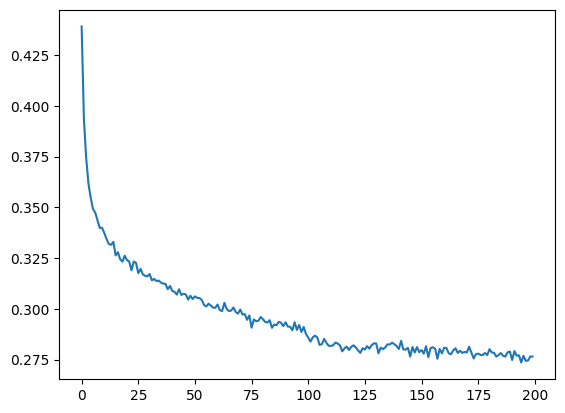

In [72]:
plt.plot(torch.tensor(loss_i).view(-1,1000).mean(1))

In [73]:
# putting the layers to eval mode (must for batch_norm)

for layer in model.layers:
    if isinstance(layer, BatchNorm1d):
        layer.Training = False

In [74]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': {X_train,Y_train},
        'dev': {X_dev,Y_dev},
        'test': {X_test,Y_test}
    }[split]

    logits = model(x)
    loss = F.cross_entropy(logits,y)

    print(split,loss.item())

split_loss('train')
split_loss('dev')


train 1.8760191202163696
dev 1.9984509944915771


#### Performance Log:

1) (context_len: 3, params: 16k, hidden_layer: 100, n_embed = 10)   

    train 2.1149344444274902   
    dev 2.139407157897949

2) (context_len: 8, params: 21k, hidden_layer: 100, n_embed = 10)   

    train 2.0303843021392822  
    dev 2.0781359672546387 

3) Introducing Wavenet Hierarchical by Adding FlattenConsecutive():  

   (context_len: 8, params: 21k, hidden_layer: 100, n_embed = 10)   

   train 2.054682970046997   
   dev 2.0895886421203613

4) Fixing the batch normalization bug:  

   (context_len: 8, params: 21k, hidden_layer: 100, n_embed = 10)   
   
   train 2.005789279937744   
   dev 2.0593481063842773

5) Scaling up the wavenet (context_len: 8, params: 77k, hidden_layer: 124, n_embed = 24):  

   train 1.8760191202163696   
   dev 1.9984509944915771 

Why convolutions ?

The actual wavenet paper have implemented the convolution NN.

Ans: Use of convolution is for efficiency, like lets take the example hilton which is a 7 examples for our model to train.

In [10]:
for x,y in zip(X_train[7:14],Y_train[7:14]):
    print(''.join(itos[i.item()] for i in x), '---->', itos[y.item()])

........ ----> h
.......h ----> i
......hi ----> l
.....hil ----> t
....hilt ----> o
...hilto ----> n
..hilton ----> .


Here we are doing 8 independent calls to our model.

Convolutions allows you to slide this model efficiently over the input sequence. So this for loop will not happen in python rather in kernels in CUDA. So this for loop gets hidden inside the convolution. its kinda a for loop appling a linear filter over a space of some input sequence.

In [ ]:
# forwarding all of them
logits = torch.zeros((7,vocab_size))
for i in range(7):
    logits[i] = model(X_train[[7+i]])
